# 🎛️ Configuration & Imports

Below we set all hyperparameters in one place (`CONFIG`), and import the libraries you’ll need.  

- **`SAMPLE_RATE`**, **`MAX_SEC`**, **`MAX_LEN`**: audio sampling and fixed-length settings  
- **`BATCH`**, **`EPOCHS`**, **`LR`**, **`K_FOLDS`**: training hyperparameters  
- We use **torchaudio** for I/O, **torchmetrics** for F1, and **tqdm** for progress bars.  


In [6]:
## 🎛️ Configuration & Imports

import random, os, gc
from pathlib import Path
from torchvision.transforms import Resize
import numpy as np
import pandas as pd
import torch
import torch.nn as nn, torch.nn.functional as F
import torchaudio
import librosa  
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from torchmetrics.classification import F1Score
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from tqdm import tqdm
import matplotlib.pyplot as plt

# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# audio parameters
SAMPLE_RATE = 16_000       # Hz
MAX_SEC     = 6.0          # seconds
MAX_LEN     = int(SAMPLE_RATE * MAX_SEC)  # samples

# training parameters
BATCH   = 64
EPOCHS  = 10
LR      = 3e-4
K_FOLDS = 5

# I/O paths
WORK_DIR  = Path("/kaggle/input/kaust-vs-kku-tournament-round-5")
TRAIN_CSV = WORK_DIR/"train.csv"
TEST_CSV  = WORK_DIR/"test.csv"
TRAIN_DIR = WORK_DIR/"train"
TEST_DIR  = WORK_DIR/"test"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)


Using device: cuda


In [4]:
pip install librosa

Note: you may need to restart the kernel to use updated packages.


## 🔍 Exploratory Data Analysis (EDA)

First, let’s load `train.csv` and `test.csv`, then show:  
1. **Distribution of reciters** in train vs. test  
2. **Histogram of Tajweed rules** in the training set  


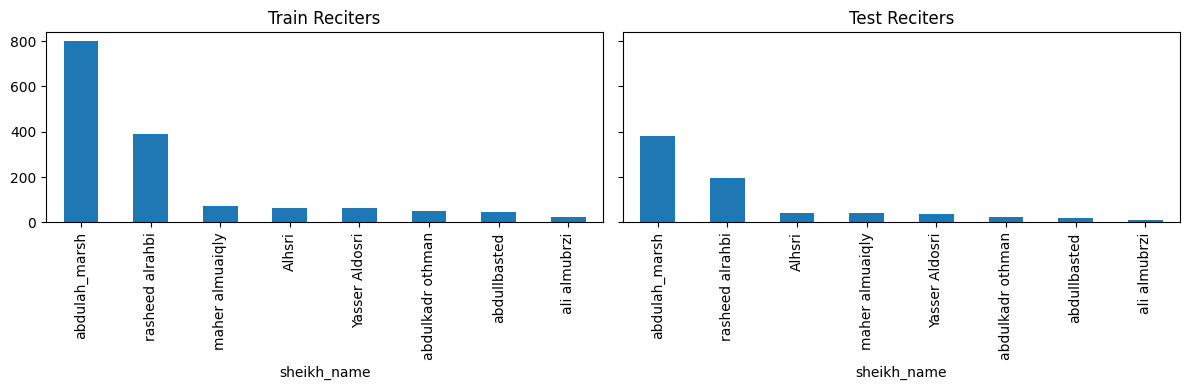

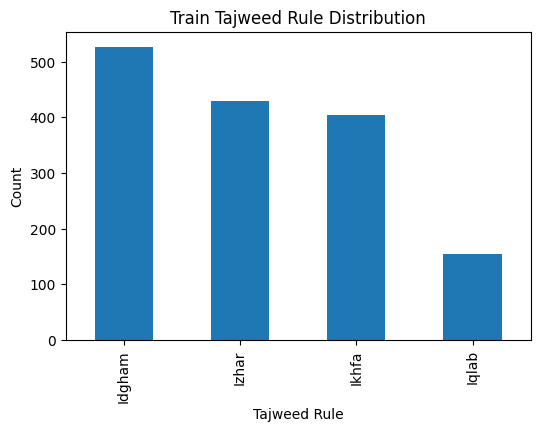

In [2]:
train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)

# Reciter distribution
fig, axes = plt.subplots(1,2, figsize=(12,4), sharey=True)
train_df.sheikh_name.value_counts().plot.bar(ax=axes[0], title="Train Reciters")
test_df .sheikh_name.value_counts().plot.bar(ax=axes[1], title="Test Reciters")
plt.tight_layout()
plt.show()

# Label histogram in train
plt.figure(figsize=(6,4))
train_df.label_name.value_counts().plot.bar(title="Train Tajweed Rule Distribution")
plt.xlabel("Tajweed Rule"); plt.ylabel("Count")
plt.show()


Processing audio lengths: 100%|██████████| 1515/1515 [00:43<00:00, 35.22it/s]


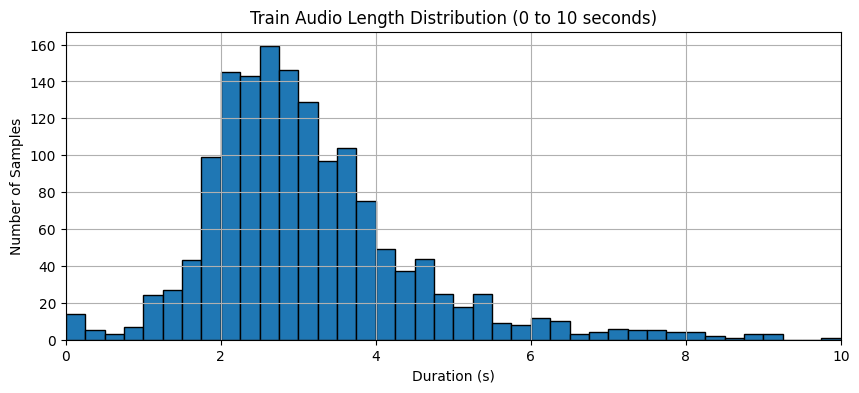

In [7]:
# Compute durations
durations = []
for audio_id in tqdm(train_df['id'], desc="Processing audio lengths"):
    file_path = os.path.join(TRAIN_DIR, f"{audio_id}.wav")
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    duration = len(y) / sr
    durations.append(duration)

# Plot
import numpy as np

# Plot with fixed range from 0 to 10 seconds
plt.figure(figsize=(10, 4))
plt.hist(durations, bins=np.arange(0, 10.1, 0.25), color='tab:blue', edgecolor='black')
plt.title("Train Audio Length Distribution (0 to 10 seconds)")
plt.xlabel("Duration (s)")
plt.ylabel("Number of Samples")
plt.xlim(0, 10)
plt.grid(True)
plt.show()

<Axes: xlabel='sheikh_name'>

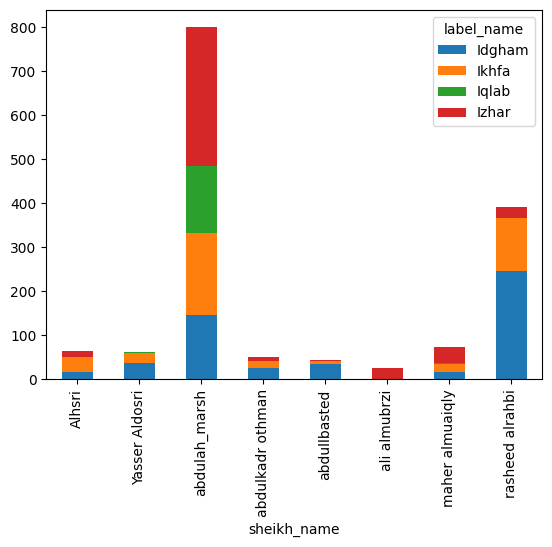

In [8]:
train_df.groupby(['sheikh_name', 'label_name']).size().unstack().plot(kind='bar', stacked=True)

In [9]:
import hashlib
def get_waveform_hash(file_path):
    waveform, sr = torchaudio.load(file_path)
    if sr != SAMPLE_RATE:
        waveform = torchaudio.functional.resample(waveform, sr, SAMPLE_RATE)
    waveform = waveform.mean(0)  # mono
    waveform_bytes = waveform.numpy().tobytes()
    return hashlib.sha256(waveform_bytes).hexdigest()

# === Hash all train files ===
train_hashes = {}
for audio_id in tqdm(train_df["id"], desc="Hashing train"):
    path = os.path.join(TRAIN_DIR, f"{audio_id}.wav")
    train_hashes[audio_id] = get_waveform_hash(path)

# === Hash all test files ===
test_hashes = set()
for audio_id in tqdm(test_df["id"], desc="Hashing test"):
    path = os.path.join(TEST_DIR, f"{audio_id}.wav")
    test_hashes.add(get_waveform_hash(path))

# === Remove leaked samples from train_df directly ===
leaked_ids = [k for k, h in train_hashes.items() if h in test_hashes]

if leaked_ids:
    print(f"🚨 Removing {len(leaked_ids)} leaked train samples...")
    train_df = train_df[~train_df["id"].isin(leaked_ids)].reset_index(drop=True)
    print(f"✅ train_df cleaned. New length: {len(train_df)}")
else:
    print("✅ No leakage found. train_df unchanged.")

Hashing test: 100%|██████████| 747/747 [00:21<00:00, 35.33it/s]

🚨 Removing 44 leaked train samples...
✅ train_df cleaned. New length: 1471


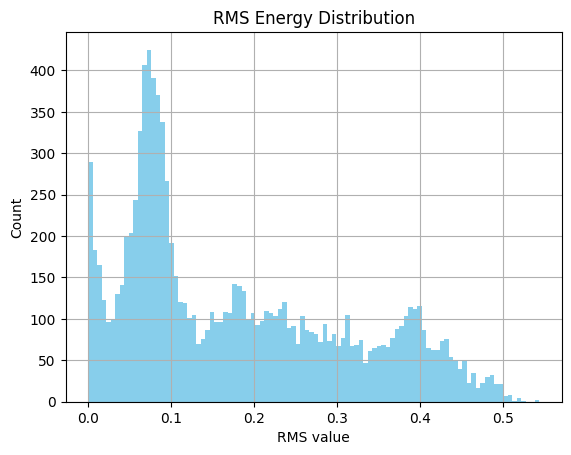

In [10]:
import librosa
import os
import numpy as np
import matplotlib.pyplot as plt

# Sample a subset (or full set) of your training data
rms_values = []
for audio_id in train_df["id"].sample(100):  # or `.head(500)` etc.
    path = os.path.join(TRAIN_DIR, f"{audio_id}.wav")
    try:
        y, _ = librosa.load(path, sr=SAMPLE_RATE)
        rms = librosa.feature.rms(y=y).flatten()
        rms_values.extend(rms)
    except Exception:
        continue

# Plot RMS distribution
plt.hist(rms_values, bins=100, color='skyblue')
plt.title("RMS Energy Distribution")
plt.xlabel("RMS value")
plt.ylabel("Count")
plt.grid(True)
plt.show()

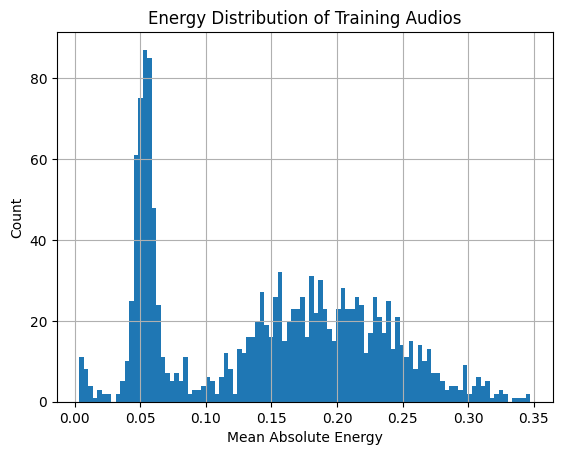

In [11]:
energies = []
for audio_id in train_df["id"]:
    path = os.path.join(TRAIN_DIR, f"{audio_id}.wav")
    waveform, _ = torchaudio.load(path)
    waveform = waveform.mean(0)
    energies.append(waveform.abs().mean().item())

plt.hist(energies, bins=100)
plt.title("Energy Distribution of Training Audios")
plt.xlabel("Mean Absolute Energy")
plt.ylabel("Count")
plt.grid(True)
plt.show()

In [12]:
import torchaudio
import os
from tqdm import tqdm

MIN_DURATION_SEC = 0.5  # threshold

# === Remove short audios from train set ===
short_train_ids = []
for audio_id in tqdm(train_df["id"], desc="Filtering short audios in train"):
    path = os.path.join(TRAIN_DIR, f"{audio_id}.wav")
    try:
        waveform, sr = torchaudio.load(path)
        duration_sec = waveform.size(1) / sr
        if duration_sec < MIN_DURATION_SEC:
            print(f"🧹 Removing short train audio: {audio_id} | {duration_sec:.2f} sec")
            short_train_ids.append(audio_id)
    except Exception as e:
        print(f"❌ Error reading {path}: {e}")

train_df = train_df[~train_df["id"].isin(short_train_ids)].reset_index(drop=True)

# === Log short audios in test set (not removed) ===
short_test_ids = []
for audio_id in tqdm(test_df["id"], desc="Logging short audios in test"):
    path = os.path.join(TEST_DIR, f"{audio_id}.wav")
    try:
        waveform, sr = torchaudio.load(path)
        duration_sec = waveform.size(1) / sr
        if duration_sec < MIN_DURATION_SEC:
            print(f"🔎 Short test audio (kept): {audio_id} | {duration_sec:.2f} sec")
            short_test_ids.append(audio_id)
    except Exception as e:
        print(f"❌ Error reading {path}: {e}")

print(f"\n✅ Removed {len(short_train_ids)} short audios from train.")
print(f"ℹ️ Detected {len(short_test_ids)} short audios in test (not removed).")

Filtering short audios in train:   2%|▏         | 28/1471 [00:00<00:16, 86.87it/s]

🧹 Removing short train audio: 11 | 0.39 sec


Filtering short audios in train:   6%|▌         | 82/1471 [00:00<00:16, 85.16it/s]

🧹 Removing short train audio: 72 | 0.25 sec


Filtering short audios in train:   9%|▊         | 128/1471 [00:01<00:15, 87.18it/s]

🧹 Removing short train audio: 121 | 0.16 sec


Filtering short audios in train:  17%|█▋        | 246/1471 [00:02<00:16, 76.50it/s]

🧹 Removing short train audio: 249 | 0.20 sec


Filtering short audios in train:  19%|█▉        | 282/1471 [00:03<00:14, 82.44it/s]

🧹 Removing short train audio: 281 | 0.44 sec


Filtering short audios in train:  30%|███       | 447/1471 [00:05<00:11, 85.55it/s]

🧹 Removing short train audio: 449 | 0.20 sec


Filtering short audios in train:  32%|███▏      | 466/1471 [00:05<00:11, 84.10it/s]

🧹 Removing short train audio: 475 | 0.21 sec


Filtering short audios in train:  34%|███▎      | 494/1471 [00:05<00:11, 87.03it/s]

🧹 Removing short train audio: 497 | 0.20 sec


Filtering short audios in train:  61%|██████    | 896/1471 [00:10<00:06, 86.70it/s]

🧹 Removing short train audio: 918 | 0.21 sec


Filtering short audios in train:  63%|██████▎   | 933/1471 [00:11<00:06, 86.36it/s]

🧹 Removing short train audio: 954 | 0.22 sec
🧹 Removing short train audio: 970 | 0.21 sec
🧹 Removing short train audio: 973 | 0.22 sec


Filtering short audios in train:  78%|███████▊  | 1146/1471 [00:13<00:03, 81.65it/s]

🧹 Removing short train audio: 1173 | 0.21 sec


Filtering short audios in train:  81%|████████  | 1192/1471 [00:14<00:03, 86.49it/s]

🧹 Removing short train audio: 1216 | 0.20 sec


Filtering short audios in train:  88%|████████▊ | 1294/1471 [00:15<00:02, 87.68it/s]

🧹 Removing short train audio: 1321 | 0.21 sec


Filtering short audios in train:  92%|█████████▏| 1349/1471 [00:16<00:01, 84.90it/s]

🧹 Removing short train audio: 1375 | 0.27 sec
🧹 Removing short train audio: 1380 | 0.26 sec


Logging short audios in test:  57%|█████▋    | 424/747 [00:04<00:03, 88.35it/s]

🔎 Short test audio (kept): 407 | 0.21 sec


Logging short audios in test:  74%|███████▍  | 551/747 [00:06<00:02, 83.92it/s]

🔎 Short test audio (kept): 534 | 0.21 sec


Logging short audios in test: 100%|██████████| 747/747 [00:08<00:00, 84.11it/s]


✅ Removed 17 short audios from train.
ℹ️ Detected 2 short audios in test (not removed).


## 🎶 Dataset: Log‑Mel Spectrograms

This `Dataset`:
1. Loads each `id.wav` from `train/` or `test/`.  
2. Resamples to 16 kHz if needed.  
3. Converts to mono, pads/trims to 4 s.  
4. Computes a **log‑Mel spectrogram** (3×128×T) for input to EfficientNet‑B0.  


In [14]:
import torchaudio
import torch
from tqdm import tqdm

# Mel spectrogram settings (same as your dataset)
mel = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=512, hop_length=256, n_mels=96
)

global_means = []
global_stds = []

for id_ in tqdm(train_df["id"], desc="Computing global stats"):
    path = TRAIN_DIR / f"{id_}.wav"
    wav, sr = torchaudio.load(path)
    wav = wav.mean(0, keepdim=True)  # mono

    if sr != SAMPLE_RATE:
        wav = torchaudio.functional.resample(wav, sr, SAMPLE_RATE)

    spec = mel(wav)
    log_spec = 10 * torch.log10(spec + 1e-6)

    global_means.append(log_spec.mean().item())
    global_stds.append(log_spec.std().item())

global_mean = sum(global_means) / len(global_means)
global_std = sum(global_stds) / len(global_stds)

print(f"Global mean: {global_mean:.4f}, Global std: {global_std:.4f}")

Computing global stats: 100%|██████████| 1454/1454 [00:25<00:00, 56.33it/s]

Global mean: -13.9018, Global std: 18.6686


In [15]:
from sklearn.preprocessing import LabelEncoder

# for train_df
le = LabelEncoder().fit(train_df["label_name"])
train_df["y"] = le.transform(train_df["label_name"])

In [16]:
import torchaudio
import torchaudio.transforms as T
import torch.nn.functional as F
from torch.utils.data import Dataset
from pathlib import Path
import torch
import random

class TajweedSpecDataset(Dataset):
    def __init__(self, df, folder, return_id=False, augment=False):
        self.df        = df.reset_index(drop=True)
        self.folder    = Path(folder)
        self.return_id = return_id
        self.augment   = augment

        # Mel-spectrogram transform
        self.mel = T.MelSpectrogram(
            sample_rate=SAMPLE_RATE,
            n_fft=512,
            hop_length=256,
            n_mels=96,
            f_min=50,
            f_max=8000
        )

        # Spec augmentations
        self.time_mask = T.TimeMasking(time_mask_param=30)
        self.freq_mask = T.FrequencyMasking(freq_mask_param=13)

    def _pad_trim(self, spec):
        T = MAX_LEN // 256  # Based on hop_length
        if spec.size(-1) < T:
            return F.pad(spec, (0, T - spec.size(-1)))
        return spec[..., :T]

    def _augment_wave(self, wav):
        # Gaussian noise
        if random.random() < 0.3:
            noise = 0.005 * torch.randn_like(wav)
            wav = wav + noise

        # Time stretching with SoX (safe range)
        if random.random() < 0.3:
            rate = random.uniform(0.9, 1.1)
            try:
                effects = [["speed", str(rate)], ["rate", str(SAMPLE_RATE)]]
                wav, _ = torchaudio.sox_effects.apply_effects_tensor(wav, SAMPLE_RATE, effects)
            except:
                pass  # fallback: leave unchanged if SoX fails

        # Random gain / volume change (±3 dB)
        if random.random() < 0.3:
            gain_db = random.uniform(-3, 3)
            wav = wav * (10.0 ** (gain_db / 20.0))

        return wav

    def _augment_spec(self, spec):
        if random.random() < 0.5:
            spec = self.time_mask(spec)
        if random.random() < 0.5:
            spec = self.freq_mask(spec)
        return spec

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = self.folder / f"{row['id']}.wav"
        wav, sr = torchaudio.load(str(path))

        if sr != SAMPLE_RATE:
            wav = torchaudio.functional.resample(wav, sr, SAMPLE_RATE)

        wav = wav.mean(0, keepdim=True)  # mono

        if self.augment:
            wav = self._augment_wave(wav)

        spec = self.mel(wav)
        spec = 10 * torch.log10(spec + 1e-6)

        if self.augment:
            spec = self._augment_spec(spec)

        spec = self._pad_trim(spec)
        spec = (spec - GLOBAL_MEAN) / (GLOBAL_STD + 1e-6)
        img = spec.repeat(3, 1, 1)
        

        if self.return_id:
            return img, row["id"]
        else:
            return img, torch.tensor(row["y"], dtype=torch.long)

    def __len__(self):
        return len(self.df)

## 🔊 Visualize Sample Spectrograms

Plot 4 random log‑Mel spectrograms from the training set.

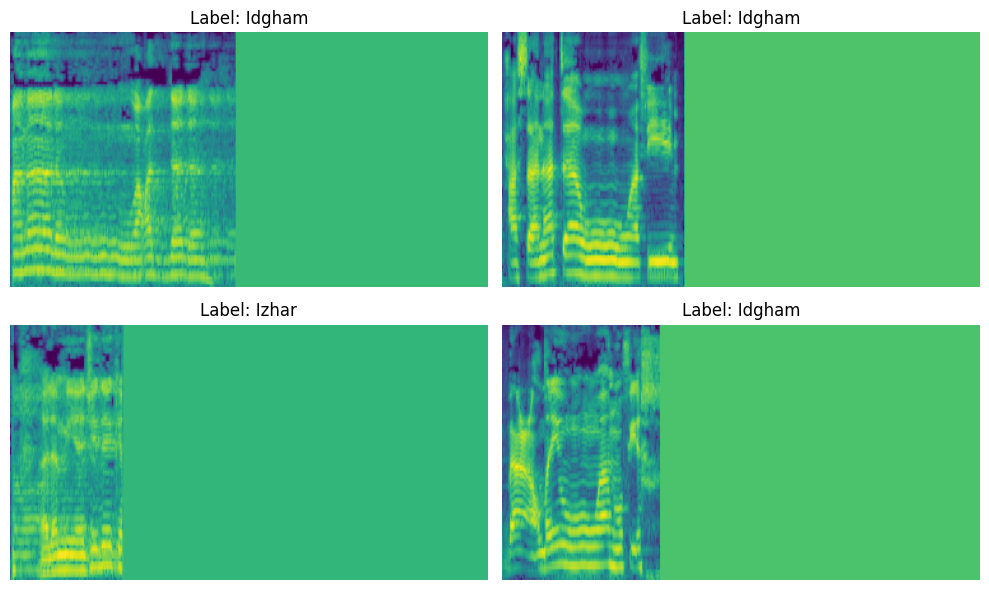

In [17]:
sample = train_df.sample(4, random_state=SEED)
ds = TajweedSpecDataset(sample, TRAIN_DIR, return_id=False)

plt.figure(figsize=(10,6))
for i, (img, lbl) in enumerate(ds):
    plt.subplot(2,2,i+1)
    plt.imshow(img[0].numpy(), aspect='auto', origin='lower')
    plt.title(f"Label: {sample.iloc[i]['label_name']}")
    plt.axis('off')
plt.tight_layout()
plt.show()


## 🏗️ Model: 

Load a pretrained model and swap its head to match our `n_classes`.

In [18]:
from torchvision.models import convnext_small, ConvNeXt_Small_Weights

def build_model(n_classes):
    weights = ConvNeXt_Small_Weights.IMAGENET1K_V1
    model = convnext_small(weights=weights)

    # Update the classifier head
    in_features = model.classifier[2].in_features
    model.classifier[2] = nn.Linear(in_features, n_classes)

    return model.to(DEVICE)

## 🔄 Training Loop with 5‑Fold Stratified CV

For each fold, we:
1. Split `train_df` by label.  
2. Train for **10 epochs**.  
3. Compute **macro‑F1** on the validation fold.  
4. Save the best checkpoint as `effb0_fold{fold}.pt`.  


In [19]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, weight=None, smoothing=0.0):
        super().__init__()
        self.gamma = gamma
        self.weight = weight
        self.smoothing = smoothing

    def forward(self, input, target):
        log_probs = torch.nn.functional.log_softmax(input, dim=1)

        if self.smoothing > 0:
            n_classes = input.size(1)
            smooth_target = torch.full_like(log_probs, self.smoothing / (n_classes - 1))
            smooth_target.scatter_(1, target.unsqueeze(1), 1.0 - self.smoothing)
        else:
            smooth_target = torch.nn.functional.one_hot(target, num_classes=input.size(1)).float()

        probs = torch.exp(log_probs)
        focal_term = (1 - probs) ** self.gamma
        loss = -smooth_target * focal_term * log_probs

        if self.weight is not None:
            loss = loss * self.weight.to(input.device)

        return loss.sum(dim=1).mean()

In [20]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight="balanced",
                                     classes=np.unique(train_df["y"]),
                                     y=train_df["y"])
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)

In [21]:
from sklearn.model_selection import StratifiedKFold

f1_scores = []
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)

for fold, (tr_idx, va_idx) in enumerate(skf.split(train_df, y=train_df.y), 1):
    # DataLoaders
    tr_dl = DataLoader(
        TajweedSpecDataset(train_df.iloc[tr_idx], TRAIN_DIR),
        batch_size=BATCH, shuffle=True,  num_workers=2, pin_memory=True
    )
    va_dl = DataLoader(
        TajweedSpecDataset(train_df.iloc[va_idx], TRAIN_DIR),
        batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True
    )

    model = build_model(n_classes=4)
    opt   = torch.optim.AdamW(model.parameters(), lr=LR)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)
    crit  = FocalLoss(gamma=2.0, smoothing=0.1, weight=class_weights)
    f1m   = F1Score(task="multiclass", num_classes=4, average="macro").to(DEVICE)

    best_f1 = 0
    for ep in range(1, EPOCHS + 1):
        # train
        model.train()
        for xb, yb in tqdm(tr_dl, desc=f"Fold{fold} Ep{ep} train"):
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            loss = crit(model(xb), yb)
            loss.backward()
            opt.step()

        # validate
        model.eval(); f1m.reset()
        with torch.no_grad():
            for xb, yb in va_dl:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                f1m.update(model(xb).softmax(1), yb)
        val_f1 = f1m.compute().item()
        sched.step()

        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), f"effb0_fold{fold}.pt")

        print(f"Fold{fold} Ep{ep:02d} | val_F1 {val_f1:.4f}")

    f1_scores.append(best_f1)
    print(f"→ Fold{fold} best val_F1 = {best_f1:.4f}\n")
    torch.cuda.empty_cache(); gc.collect()

print("CV val_F1 scores:", f1_scores, "→ mean", np.mean(f1_scores))

Downloading: "https://download.pytorch.org/models/convnext_small-0c510722.pth" to /root/.cache/torch/hub/checkpoints/convnext_small-0c510722.pth
100%|██████████| 192M/192M [00:00<00:00, 204MB/s]  
Fold1 Ep1 train: 100%|██████████| 19/19 [00:24<00:00,  1.29s/it]


Fold1 Ep01 | val_F1 0.2813


Fold1 Ep2 train: 100%|██████████| 19/19 [00:23<00:00,  1.22s/it]


Fold1 Ep02 | val_F1 0.4352


Fold1 Ep3 train: 100%|██████████| 19/19 [00:23<00:00,  1.26s/it]


Fold1 Ep03 | val_F1 0.5355


Fold1 Ep4 train: 100%|██████████| 19/19 [00:24<00:00,  1.28s/it]


Fold1 Ep04 | val_F1 0.6426


Fold1 Ep5 train: 100%|██████████| 19/19 [00:25<00:00,  1.33s/it]


Fold1 Ep05 | val_F1 0.8627


Fold1 Ep6 train: 100%|██████████| 19/19 [00:24<00:00,  1.29s/it]


Fold1 Ep06 | val_F1 0.9207


Fold1 Ep7 train: 100%|██████████| 19/19 [00:24<00:00,  1.28s/it]


Fold1 Ep07 | val_F1 0.9259


Fold1 Ep8 train: 100%|██████████| 19/19 [00:24<00:00,  1.30s/it]


Fold1 Ep08 | val_F1 0.9285


Fold1 Ep9 train: 100%|██████████| 19/19 [00:25<00:00,  1.34s/it]


Fold1 Ep09 | val_F1 0.9430


Fold1 Ep10 train: 100%|██████████| 19/19 [00:24<00:00,  1.30s/it]


Fold1 Ep10 | val_F1 0.9365
→ Fold1 best val_F1 = 0.9430



Fold2 Ep1 train: 100%|██████████| 19/19 [00:24<00:00,  1.30s/it]


Fold2 Ep01 | val_F1 0.3840


Fold2 Ep2 train: 100%|██████████| 19/19 [00:24<00:00,  1.30s/it]


Fold2 Ep02 | val_F1 0.8845


Fold2 Ep3 train: 100%|██████████| 19/19 [00:24<00:00,  1.30s/it]


Fold2 Ep03 | val_F1 0.9339


Fold2 Ep4 train: 100%|██████████| 19/19 [00:24<00:00,  1.30s/it]


Fold2 Ep04 | val_F1 0.9498


Fold2 Ep5 train: 100%|██████████| 19/19 [00:25<00:00,  1.32s/it]


Fold2 Ep05 | val_F1 0.9535


Fold2 Ep6 train: 100%|██████████| 19/19 [00:24<00:00,  1.29s/it]


Fold2 Ep06 | val_F1 0.9319


Fold2 Ep7 train: 100%|██████████| 19/19 [00:24<00:00,  1.30s/it]


Fold2 Ep07 | val_F1 0.9382


Fold2 Ep8 train: 100%|██████████| 19/19 [00:24<00:00,  1.29s/it]


Fold2 Ep08 | val_F1 0.9474


Fold2 Ep9 train: 100%|██████████| 19/19 [00:24<00:00,  1.29s/it]


Fold2 Ep09 | val_F1 0.9471


Fold2 Ep10 train: 100%|██████████| 19/19 [00:24<00:00,  1.30s/it]


Fold2 Ep10 | val_F1 0.9444
→ Fold2 best val_F1 = 0.9535



Fold3 Ep1 train: 100%|██████████| 19/19 [00:24<00:00,  1.30s/it]


Fold3 Ep01 | val_F1 0.4135


Fold3 Ep2 train: 100%|██████████| 19/19 [00:24<00:00,  1.30s/it]


Fold3 Ep02 | val_F1 0.6909


Fold3 Ep3 train: 100%|██████████| 19/19 [00:24<00:00,  1.30s/it]


Fold3 Ep03 | val_F1 0.8884


Fold3 Ep4 train: 100%|██████████| 19/19 [00:24<00:00,  1.29s/it]


Fold3 Ep04 | val_F1 0.9242


Fold3 Ep5 train: 100%|██████████| 19/19 [00:24<00:00,  1.31s/it]


Fold3 Ep05 | val_F1 0.9265


Fold3 Ep6 train: 100%|██████████| 19/19 [00:24<00:00,  1.30s/it]


Fold3 Ep06 | val_F1 0.9316


Fold3 Ep7 train: 100%|██████████| 19/19 [00:24<00:00,  1.30s/it]


Fold3 Ep07 | val_F1 0.9386


Fold3 Ep8 train: 100%|██████████| 19/19 [00:24<00:00,  1.29s/it]


Fold3 Ep08 | val_F1 0.9344


Fold3 Ep9 train: 100%|██████████| 19/19 [00:24<00:00,  1.30s/it]


Fold3 Ep09 | val_F1 0.9322


Fold3 Ep10 train: 100%|██████████| 19/19 [00:24<00:00,  1.30s/it]


Fold3 Ep10 | val_F1 0.9440
→ Fold3 best val_F1 = 0.9440



Fold4 Ep1 train: 100%|██████████| 19/19 [00:24<00:00,  1.29s/it]


Fold4 Ep01 | val_F1 0.2863


Fold4 Ep2 train: 100%|██████████| 19/19 [00:24<00:00,  1.32s/it]


Fold4 Ep02 | val_F1 0.5943


Fold4 Ep3 train: 100%|██████████| 19/19 [00:25<00:00,  1.34s/it]


Fold4 Ep03 | val_F1 0.6720


Fold4 Ep4 train: 100%|██████████| 19/19 [00:24<00:00,  1.30s/it]


Fold4 Ep04 | val_F1 0.9316


Fold4 Ep5 train: 100%|██████████| 19/19 [00:24<00:00,  1.29s/it]


Fold4 Ep05 | val_F1 0.9497


Fold4 Ep6 train: 100%|██████████| 19/19 [00:24<00:00,  1.30s/it]


Fold4 Ep06 | val_F1 0.9462


Fold4 Ep7 train: 100%|██████████| 19/19 [00:24<00:00,  1.30s/it]


Fold4 Ep07 | val_F1 0.9401


Fold4 Ep8 train: 100%|██████████| 19/19 [00:24<00:00,  1.29s/it]


Fold4 Ep08 | val_F1 0.9510


Fold4 Ep9 train: 100%|██████████| 19/19 [00:25<00:00,  1.33s/it]


Fold4 Ep09 | val_F1 0.9501


Fold4 Ep10 train: 100%|██████████| 19/19 [00:24<00:00,  1.30s/it]


Fold4 Ep10 | val_F1 0.9501
→ Fold4 best val_F1 = 0.9510



Fold5 Ep1 train: 100%|██████████| 19/19 [00:24<00:00,  1.30s/it]


Fold5 Ep01 | val_F1 0.2891


Fold5 Ep2 train: 100%|██████████| 19/19 [00:24<00:00,  1.30s/it]


Fold5 Ep02 | val_F1 0.6577


Fold5 Ep3 train: 100%|██████████| 19/19 [00:25<00:00,  1.34s/it]


Fold5 Ep03 | val_F1 0.8014


Fold5 Ep4 train: 100%|██████████| 19/19 [00:24<00:00,  1.30s/it]


Fold5 Ep04 | val_F1 0.8970


Fold5 Ep5 train: 100%|██████████| 19/19 [00:24<00:00,  1.30s/it]


Fold5 Ep05 | val_F1 0.9520


Fold5 Ep6 train: 100%|██████████| 19/19 [00:24<00:00,  1.30s/it]


Fold5 Ep06 | val_F1 0.9572


Fold5 Ep7 train: 100%|██████████| 19/19 [00:24<00:00,  1.30s/it]


Fold5 Ep07 | val_F1 0.9509


Fold5 Ep8 train: 100%|██████████| 19/19 [00:24<00:00,  1.30s/it]


Fold5 Ep08 | val_F1 0.9626


Fold5 Ep9 train: 100%|██████████| 19/19 [00:24<00:00,  1.30s/it]


Fold5 Ep09 | val_F1 0.9659


Fold5 Ep10 train: 100%|██████████| 19/19 [00:24<00:00,  1.30s/it]


Fold5 Ep10 | val_F1 0.9717
→ Fold5 best val_F1 = 0.9717

CV val_F1 scores: [0.9430015683174133, 0.9535455703735352, 0.9440131187438965, 0.9509872198104858, 0.9717153310775757] → mean 0.9526525616645813


## 🧪 Inference & Submission

Load each fold’s best model, average their softmax outputs on the test set, and write out `submission.csv`.

In [22]:
def apply_tta(spec):
    if random.random() < 0.5:
        spec = torchaudio.transforms.TimeMasking(time_mask_param=30)(spec)
    if random.random() < 0.5:
        spec = torchaudio.transforms.FrequencyMasking(freq_mask_param=13)(spec)
    return spec

In [24]:
# 1) Build inference loader
infer_dl = DataLoader(
    TajweedSpecDataset(test_df, TEST_DIR, return_id=True),
    batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True
)

# 2) Collect logits from each fold with TTA
all_logits = []
TTA_ROUNDS = 5

for fold in range(1, K_FOLDS + 1):
    m = build_model(n_classes=4)
    m.load_state_dict(torch.load(f"effb0_fold{fold}.pt"))
    m.eval()
    fold_logits = []

    with torch.no_grad():
        for xb, _ids in tqdm(infer_dl, desc=f"Infer fold{fold} w/ TTA"):
            xb = xb.to(DEVICE)
            tta_preds = []
            for _ in range(TTA_ROUNDS):
                xb_aug = xb.clone()
                for i in range(xb.size(0)):
                    xb_aug[i] = apply_tta(xb_aug[i])  # Your custom TTA function
                tta_preds.append(m(xb_aug).softmax(1).cpu())  # Softmax for stability
            mean_pred = torch.stack(tta_preds).mean(0)
            fold_logits.append(mean_pred)

    all_logits.append(torch.cat(fold_logits, dim=0))

# 3) Average predictions across folds
avg_logits = torch.stack(all_logits).mean(0)

# 4) Decode predictions
pred_ids = avg_logits.argmax(1).numpy()
pred_labels = le.inverse_transform(pred_ids)  # le must be your fitted LabelEncoder

# 5) Save submission
submission = pd.DataFrame({
    "id": infer_dl.dataset.df["id"].astype(int),
    "label_name": pred_labels
})
submission.to_csv("submission.csv", index=False)
print("✅ Saved submission.csv")

Infer fold5 w/ TTA: 100%|██████████| 12/12 [00:21<00:00,  1.79s/it]

✅ Saved submission.csv


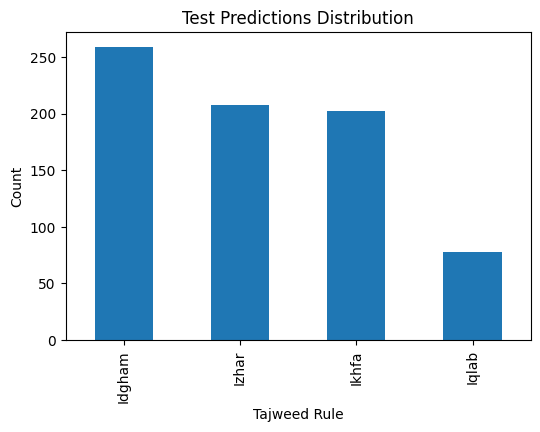

In [25]:
# 5) Plot test‐prediction distribution
plt.figure(figsize=(6,4))
submission.label_name.value_counts().plot.bar(title="Test Predictions Distribution")
plt.xlabel("Tajweed Rule"); plt.ylabel("Count"); plt.show()
